In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import string

In [2]:
df = pd.read_csv('archive(2)/test.csv')

In [3]:
df.rename({'im feeling rather rotten so im not very ambitious right now;sadness':'text'}, axis=1, inplace=True)

In [4]:
df.head()

,text
0,im updating my blog because i feel shitty;sadness
1,i never make her separate from me because i do...
2,i left with my bouquet of red and yellow tulip...
3,i was feeling a little vain when i did this on...
4,i cant walk into a shop anywhere where i do no...


In [5]:
df[['text', 'label']] = df['text'].str.split(';', 1, expand=True)

In [6]:
df.head()

,text,label
0,im updating my blog because i feel shitty,sadness
1,i never make her separate from me because i do...,sadness
2,i left with my bouquet of red and yellow tulip...,joy
3,i was feeling a little vain when i did this one,sadness
4,i cant walk into a shop anywhere where i do no...,fear


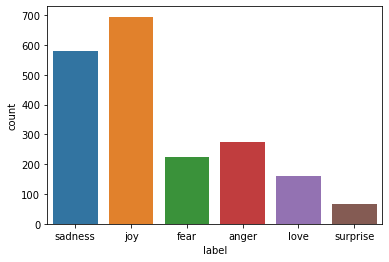

In [7]:
sns.countplot(data=df, x='label')

In [8]:
#Let's see if the length of the message affects the label 
df['text_len'] = df['text'].apply(lambda x: len(x))
df_bylabel = df.groupby('label').sum()

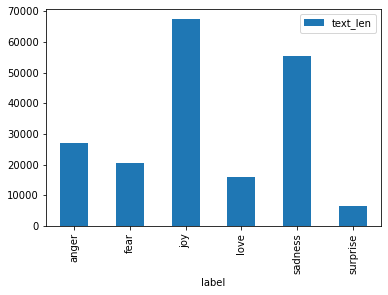

In [9]:
df_bylabel.plot.bar()
#We see the same distribution per category

In [10]:
#Let's process the data
for i in df['text']: 
    if '' in i:
        print('punc') 

punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc
punc


In [11]:
#1) Remove the punctuation
#df['text'] = df['text'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

In [12]:
#2) Remove the stopwords
#First, modify the 
#df['text'] = df['text'].apply(lambda x: x.split())


In [13]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
#Now let's tokenize the data
df['text'] = df['text'].apply(text_process)

In [15]:
df

,text,label,text_len
0,"[im, updating, blog, feel, shitty]",sadness,41
1,"[never, make, separate, ever, want, feel, like...",sadness,97
2,"[left, bouquet, red, yellow, tulips, arm, feel...",joy,113
3,"[feeling, little, vain, one]",sadness,47
4,"[cant, walk, shop, anywhere, feel, uncomfortable]",fear,66
...,...,...,...
1994,"[keep, feeling, like, someone, unkind, wrong, ...",anger,163
1995,"[im, feeling, little, cranky, negative, doctor...",anger,66
1996,"[feel, useful, people, gives, great, feeling, ...",joy,85
1997,"[im, feeling, comfortable, derby, feel, though...",joy,88


In [16]:
#Time to create the Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['text'])

In [18]:
text_bow = bow_transformer.transform(df['text'])

In [19]:
print('Shape of Sparse Matrix: ', text_bow.shape)
print('Amount of Non-Zero occurences: ', text_bow.nnz)

Shape of Sparse Matrix:  (1999, 1998)
Amount of Non-Zero occurences:  1999


In [20]:
sparsity = (100.0 * text_bow.nnz / (text_bow.shape[0] * text_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(text_bow)
text_tfidf = tfidf_transformer.transform(text_bow)
print(text_tfidf.shape)

(1999, 1998)


In [22]:
from sklearn.naive_bayes import MultinomialNB
sentiment_analysis_model = MultinomialNB().fit(text_tfidf, df['label'])

In [23]:
all_predictions = sentiment_analysis_model.predict(text_tfidf)
print(all_predictions)

['sadness' 'sadness' 'joy' ... 'joy' 'joy' 'joy']


In [24]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(df['text'], df['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

1599 400 1999


In [25]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [26]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000025A7CB4F310>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [27]:
predictions = pipeline.predict(msg_test)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00         0
         joy       1.00      0.31      0.48       400
        love       0.00      0.00      0.00         0
     sadness       0.00      0.00      0.00         0
    surprise       0.00      0.00      0.00         0

    accuracy                           0.31       400
   macro avg       0.17      0.05      0.08       400
weighted avg       1.00      0.31      0.48       400



C:\Users\Kamen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
#Try RFC!
from sklearn import preprocessing
Encode = preprocessing.LabelEncoder()
from sklearn.ensemble import RandomForestClassifier

In [30]:
rfc = RandomForestClassifier(max_depth=10,max_features=10)
vect = CountVectorizer()
msg_train_vect = vect.fit_transform(msg_train)
rfc.fit(msg_train_vect,label_train)
#msg_train

AttributeError: 'list' object has no attribute 'lower'